# Collaborative filtering

Sources
* [Introduction to Recommender Systems in 2019](https://tryolabs.com/blog/introduction-to-recommender-systems/) - tryo labs
* [Fast.ai Lesson 4: Deep Learning 2019 - NLP; Tabular data; Collaborative filtering; Embeddings](https://www.youtube.com/watch?v=qqt3aMPB81c&t=4046s) (From 1h07m28s)
    * [Lesson page](https://course.fast.ai/videos/?lesson=4)

In [1]:
%matplotlib inline

import sys
import io
import urllib
import zipfile
from typing import Tuple
from pathlib import Path

import tqdm
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [2]:
np.random.seed(42)

In [3]:
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
file_path = Path('~/Downloads/datasets/ml-latest-small.zip').expanduser()
with zipfile.ZipFile(file_path, 'r') as archive:
    with archive.open('ml-latest-small/ratings.csv') as file:
        df = pd.read_csv(
            file, low_memory=False, header=0)
    with archive.open('ml-latest-small/movies.csv') as file:
        df_movies = pd.read_csv(
            file, low_memory=False, header=0, index_col=0)
        
            
# Delete timestamp column which is not needed
del df['timestamp']

In [4]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
print(len(df_movies))
df_movies.head()

9742


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [6]:
idx2userid = df.userId.unique().tolist()
userid2idx = {
    uid:i for i, uid in enumerate(idx2userid)}
idx2movieid = df.movieId.unique().tolist()
movieid2idx = {
    mid:i for i, mid in enumerate(idx2movieid)}

In [7]:
all_users = torch.LongTensor(idx2userid)
print('all_users: ', all_users.shape)

all_items = torch.LongTensor(idx2movieid)
print('all_items: ', all_items.shape)

min_rating = df.rating.min()
print('min_rating: ', min_rating)
max_rating = df.rating.max()
print('max_rating: ', max_rating)

all_users:  torch.Size([610])
all_items:  torch.Size([9724])
min_rating:  0.5
max_rating:  5.0


In [8]:
# PyTorch dataset

class MovieLensDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = df.iloc[[idx]]
        user_id = sample.userId.item()
        movie_id = sample.movieId.item()
        rating = sample.rating.item()
        return userid2idx[user_id], movieid2idx[movie_id], rating

    
dataset = MovieLensDataset(df)

dataset_size = len(dataset)
print('dataset size: ', dataset_size)
print('Sample from dataset: ', dataset[0])

dataset size:  100836
Sample from dataset:  (0, 0, 4.0)


In [9]:
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size])
print('train_dataset: ', len(train_dataset))
print('val_dataset: ', len(val_dataset))

train_dataset:  90752
val_dataset:  10084


In [10]:
def collate_fn(batch):
    user_ids, movie_ids, ratings = zip(*batch)
    return (
        torch.stack([torch.as_tensor(u) for u in user_ids]).long(),
        torch.stack([torch.as_tensor(m) for m in movie_ids]).long(),
        torch.stack([torch.as_tensor(r) for r in ratings]).float(),
    )
    

train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn)
print('train_loader: ', len(train_loader))
train_batch = next(iter(train_loader))
print(f'train_batch len={len(train_batch)}')
print(f'train_batch[0] {train_batch[0].dtype}, {train_batch[0].shape}')
print(f'train_batch[1] {train_batch[1].dtype}, {train_batch[1].shape}')
print(f'train_batch[2] {train_batch[2].dtype}, {train_batch[2].shape}')


val_loader = DataLoader(
    val_dataset, batch_size=512, collate_fn=collate_fn)
print('val_loader: ', len(val_loader))
val_batch = next(iter(val_loader))
print(f'val_batch len={len(val_batch)}')
print(f'val_batch[0] {val_batch[0].dtype}, {val_batch[0].shape}')
print(f'val_batch[1] {val_batch[1].dtype}, {val_batch[1].shape}')
print(f'val_batch[2] {val_batch[2].dtype}, {val_batch[2].shape}')

train_loader:  178
train_batch len=3
train_batch[0] torch.int64, torch.Size([512])
train_batch[1] torch.int64, torch.Size([512])
train_batch[2] torch.float32, torch.Size([512])
val_loader:  20
val_batch len=3
val_batch[0] torch.int64, torch.Size([512])
val_batch[1] torch.int64, torch.Size([512])
val_batch[2] torch.float32, torch.Size([512])


In [11]:
# Create embedding modules
# Code from fast.ai lib

def trunc_normal_(x:torch.Tensor, mean:float=0., std:float=1.) -> torch.Tensor:
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)


def embedding(ni:int, nf:int) -> torch.nn.Module:
    """Create an embedding layer."""
    emb = torch.nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb


class EmbeddingDotBias(torch.nn.Module):
    """Base dot model for collaborative filtering."""
    # https://github.com/fastai/fastai/blob/master/fastai/collab.py#L36
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
    
    def forward(self, users:torch.LongTensor, items:torch.LongTensor) -> torch.Tensor:
        dot = self.u_weight(users) * self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

In [12]:
model = EmbeddingDotBias(
    n_factors=2,
    n_users=len(all_users),
    n_items=len(all_items),
    y_range=(min_rating, max_rating))

print('model: ', model)

model:  EmbeddingDotBias(
  (u_weight): Embedding(610, 2)
  (i_weight): Embedding(9724, 2)
  (u_bias): Embedding(610, 1)
  (i_bias): Embedding(9724, 1)
)


In [13]:
loss_fun = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)

In [14]:
def validate(model, val_loader):
    total_val_loss = 0.
    total_nb = 0
    for batch in val_loader:
        users, movies, ratings = batch
        ratings_pred = model(users, movies)
        total_val_loss += torch.nn.functional.l1_loss(
            ratings_pred, ratings, reduction='sum')
        total_nb += len(users)
    return total_val_loss / total_nb

In [15]:
n_epochs = 5
n_batches = len(train_loader)
total_iter = n_epochs * n_batches


losses = []
val_losses = [(0, validate(model, val_loader))]

count = 0
with tqdm.tqdm(total=total_iter, file=sys.stdout) as pbar:
    for e in range(n_epochs):
        for batch_idx, batch in enumerate(train_loader):
            users, movies, ratings = batch
            optimizer.zero_grad()
            ratings_pred = model(users, movies)
            loss = loss_fun(ratings_pred, ratings)
            loss.backward()
            optimizer.step()
            count += 1
            losses.append((count, loss.item()))
            pbar.set_description(
                f'epoch={e} batch={batch_idx} loss={loss.item():.2f}')
            pbar.update(1)
        val_loss = validate(model, val_loader)
        val_losses.append((count, val_loss))

epoch=4 batch=177 loss=0.27: 100%|██████████| 890/890 [04:08<00:00,  3.58it/s]


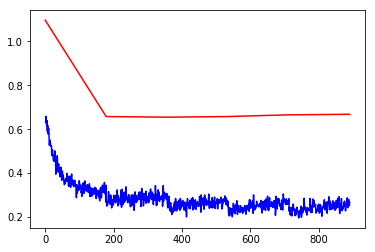

In [16]:
plt.figure()
plt.plot(*zip(*losses), 'b')
plt.plot(*zip(*val_losses), 'r')
plt.show()

In [17]:
for idx, movie_id in enumerate(all_items):
    emb = model.i_weight.weight[idx, :]
    
    
df_embeddings = pd.DataFrame({ 
    'x1': model.i_weight.weight[:,0].tolist(),
    'x2': model.i_weight.weight[:,1].tolist()},
    index=all_items.tolist(),)
df_embeddings = df_embeddings.join(df_movies, how='left')
df_embeddings.head()

,x1,x2,title,genres
1,-0.030388,-0.562548,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,0.179471,-0.678881,Grumpier Old Men (1995),Comedy|Romance
6,-0.004492,-0.729571,Heat (1995),Action|Crime|Thriller
47,-0.317879,-0.310709,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
50,-0.517074,-0.866122,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [18]:
ids_color_subset = [
    (1, 'blue'), # Toy Story (1995)
    (3114, 'blue'),  # Toy Story 2 (1999)
    (78499, 'blue'), # Toy Story 3 (2010)
    (60069, 'darkblue'), # WALL·E (2008)
    (3793, 'darkmagenta'), # X-Men (2000)
    (6333,  'darkmagenta'), # X2: X-Men United (2003)
    (45499, 'darkmagenta'), # X-Men: The Last Stand (2006)
    (68319, 'darkmagenta'), # X-Men Origins: Wolverine (2009)
    (87232, 'darkmagenta'), # X-Men: First Class (2011)
    (111362, 'darkmagenta'), # X-Men: Days of Future Past (2014)
    (122924, 'darkmagenta'), # X-Men: Apocalypse (2016)
    (59784, 'cyan'), # Kung Fu Panda (2008)
    (67295, 'cyan'), # Kung Fu Panda: Secrets of the Furious Five (2008)
    (87222, 'cyan'), # Kung Fu Panda 2 (2011)
    (136556, 'cyan'), # Kung Fu Panda: Secrets of the Masters (2011)
    (149406, 'cyan'), # Kung Fu Panda 3 (2016)
    (1090, 'red'), # Platoon (1986)
    (1222, 'red'), # Full Metal Jacket (1987)
    (1208, 'red'), # Apocalypse Now (1979)
    (1263, 'red'), # Deer Hunter, The (1978)
    (858,    'firebrick'), # Godfather, The (1972)
    (1221,   'firebrick'), # Godfather: Part II, The (1974)
    (2023,   'firebrick'), # Godfather: Part III, The (1990)
    (260, 'orange'), # Star Wars: Episode IV - A New Hope (1977)
    (1196, 'orange'), # Star Wars: Episode V - The Empire Strikes Back (1980)
    (1210, 'orange'), # Star Wars: Episode VI - Return of the Jedi (1983)
    (2628, 'darkorange'), # Star Wars: Episode I - The Phantom Menace (1999)
    (5378, 'darkorange'), # Star Wars: Episode II - Attack of the Clones (2002)
    (33493, 'darkoragne'), # Star Wars: Episode III - Revenge of the Sith (2005)
    (1214, 'darkgreen'),  # Alien (1979)
    (1200, 'darkgreen'),  # Aliens (1986)
    (1320, 'darkgreen'), # Alien³ (a.k.a. Alien 3) (1992)
    (1690, 'darkgreen'),  # Alien: Resurrection (1997)
]

ids_subset, color_subset = zip(*ids_color_subset)


df_emb_subset = df_embeddings.loc[list(ids_subset)]
df_emb_subset['color'] = list(color_subset)
  
df_emb_subset.head()

,x1,x2,title,genres,color
1,-0.030388,-0.562548,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,blue
3114,0.209939,-0.542673,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,blue
78499,0.139753,-0.369522,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,blue
60069,-0.481534,0.212003,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,darkblue
3793,0.413684,-0.026713,X-Men (2000),Action|Adventure|Sci-Fi,darkmagenta


In [19]:
from bokeh.plotting import figure, show, ColumnDataSource

source = ColumnDataSource(df_emb_subset)

tooltips = [
    ("title", "@title"),
    ("genres", "@genres"),
]

p = figure(title="Movies", tooltips=tooltips)
p.circle('x1', 'x2', color='color', fill_alpha=0.5, size=10, source=source)
show(p)